<a href="https://colab.research.google.com/github/mawady/cv-recipes/blob/main/ResNet18_MultiClass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Info
Developed by Dr. Mohamed Elawady - [[Website](https://mawady.github.io)] - [[Linkedin](https://www.linkedin.com/in/mawady/)]

---

In [ ]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from os import scandir
import copy
from shutil import copyfile
#import zipfile
import random
import pickle
from tqdm import tqdm

plt.ion()   # interactive mode



In [ ]:
# Ref: https://gist.github.com/fukuroder/caa351677bf718a8bfe6265c2a45211f
import os
import cv2
import numpy as np
train_image = 'train-images-idx3-ubyte'
train_label = 'train-labels-idx1-ubyte'
test_image = 't10k-images-idx3-ubyte'
test_label = 't10k-labels-idx1-ubyte'
for f in [train_image, train_label, test_image, test_label]:
  os.system('wget --no-check-certificate http://yann.lecun.com/exdb/mnist/%s.gz' % (f,))
for f in [train_image, train_label, test_image, test_label]:
  os.system('gunzip %s.gz' % (f,))
for type_f,image_f, label_f in [("train", train_image, train_label), ("val", test_image, test_label)]:
  with open(image_f, 'rb') as f:
    images = f.read()
  with open(label_f, 'rb') as f:
    labels = f.read()
  images = [d for d in images[16:]]
  images = np.array(images, dtype=np.uint8)
  images = images.reshape((-1,28,28))
  labels = dict([(k, l) for k,l in enumerate(labels[8:])])
  outDir = "MNIST/{}".format(type_f)
  for k,image in enumerate(images):
    imgDir = os.path.join(outDir,str(labels[k]))
    if not os.path.isdir(imgDir):
      os.makedirs(imgDir)
    cv2.imwrite(os.path.join(imgDir, '%05d.png' % (k,)), image)

## Loading in the data
The dataset is already split into training and validation subfolders:


*   /train contains all images from the Leeds Butterfly set, in per-class named subfolders, except for 10 images each held back for the validation set.
*   /val contains 10 images from each 10 classes in per-class named subfolders.




In [ ]:
# loading in data from set in Drive
datapath = "/content/MNIST"
print(os.listdir(datapath))
print(os.listdir("{}/train".format(datapath)))



['train', 'val']
['6', '1', '0', '4', '3', '8', '7', '2', '9', '5']


In [ ]:
training_path = "{}/train".format(datapath)
validation_path = "{}/val".format(datapath)
# Count files in subdirectories

def file_count(path):
   return sum(len(files) for _, _, files in os.walk(path))

print("training set:", len(os.listdir(training_path))," classes, ", file_count(training_path), " files in subfolders")
print("validation set:", len(os.listdir(validation_path)), " classes, ", file_count(validation_path), " files in subfolders")


training set: 10  classes,  60000  files in subfolders
validation set: 10  classes,  10000  files in subfolders


In [ ]:
# Showing some pictures
# this loads in ALL the images and is slow. better would be to use reservoir sampling (cell below)
from PIL import Image

images = []
for folder in os.listdir(training_path):
  for image in os.listdir(training_path + '/' + folder):
    images.append(os.path.join(training_path, folder, image))

Transforms:
1. Preprocessing:
In order to use our images with a network pretrained on the ImageNet dataset, we need to preprocess our images in the same way as the in the pretrained network. For that, we need to rescale the images to 224×224 and normalize them as per ImageNet standards. We can use the torchvision transforms:


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# DataLoaders
data_dir = datapath
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print class names & set sizes
print(class_names)
print(dataset_sizes)
print(type(dataloaders['train']))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{'train': 60000, 'val': 10000}
<class 'torch.utils.data.dataloader.DataLoader'>


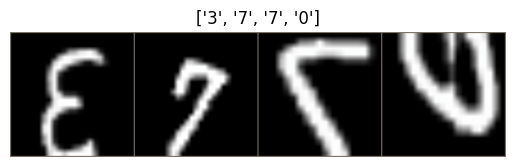

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # how to set actual result in the title too?
                #ax.set_title('predicted: {}'.format(class_names[preds[j]]), 'correct: {}'.format((labels[j] == class_names[preds[j]])))
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=4)

Epoch 0/3
----------


100%|██████████| 469/469 [03:27<00:00,  2.26it/s]


train Loss: 0.3833 Acc: 0.8701


100%|██████████| 79/79 [00:21<00:00,  3.65it/s]


val Loss: 0.0409 Acc: 0.9871

Epoch 1/3
----------


100%|██████████| 469/469 [03:27<00:00,  2.26it/s]


train Loss: 0.3558 Acc: 0.8782


100%|██████████| 79/79 [00:23<00:00,  3.41it/s]


val Loss: 0.0370 Acc: 0.9884

Epoch 2/3
----------


100%|██████████| 469/469 [03:27<00:00,  2.26it/s]


train Loss: 0.3480 Acc: 0.8819


100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


val Loss: 0.0383 Acc: 0.9879

Epoch 3/3
----------


100%|██████████| 469/469 [03:26<00:00,  2.27it/s]


train Loss: 0.3365 Acc: 0.8851


100%|██████████| 79/79 [00:23<00:00,  3.39it/s]

val Loss: 0.0356 Acc: 0.9887

Training complete in 15m 18s
Best val Acc: 0.988700


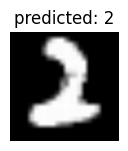

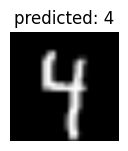

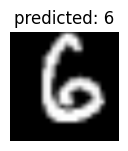

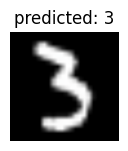

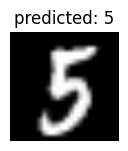

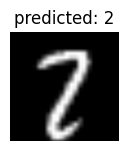

In [ ]:
visualize_model(model_ft)
# how to show if it is correctly classified or not?

In [ ]:
torch.save(model_ft.state_dict(), '/tmp/model_state.pth')

In [ ]:
pickle.dump(class_names, open("/tmp/class_names.pkl", "wb"), pickle.HIGHEST_PROTOCOL)